In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from helper_functions import *
importTensorflow(memory=4090)
precision()

2.15.0
1 Physical GPUs, 1 Logical GPUs
<Policy "mixed_float16">


In [2]:
import tensorflow_datasets as tfds
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)
class_names = ds_info.features["label"].names

In [3]:
img_shape = (128, 128, 3)
def preprocess_img(image, label, img_shape=img_shape[0]):
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [4]:
from tensorflow.keras import layers

base_model1 = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
base_model1.trainable = False
base_model2 = tf.keras.applications.EfficientNetV2S(include_top=False)
base_model2.train_data = False
inputs = layers.Input(shape=img_shape, name="input_layer")
# x = data_aug(inputs, training=False)
x1 = base_model1(inputs, training=False)
x2 = base_model2(inputs, training=False)

x1 = layers.GlobalAveragePooling2D(name="pooling_layer1")(x1)
x2 = layers.GlobalAveragePooling2D(name="pooling_layer2")(x2)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
x1 = tf.keras.layers.Dropout(0.2)(x1)
x2 = tf.keras.layers.Dropout(0.2)(x2)
# x = tf.keras.layers.Dense(32, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
concat = tf.keras.layers.Concatenate()([x1,x2])
outputs = layers.Dense(len(class_names), activation=tf.keras.activations.softmax, dtype=tf.float32)(concat)
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy()])
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch:3e-3/10**(epoch/5))

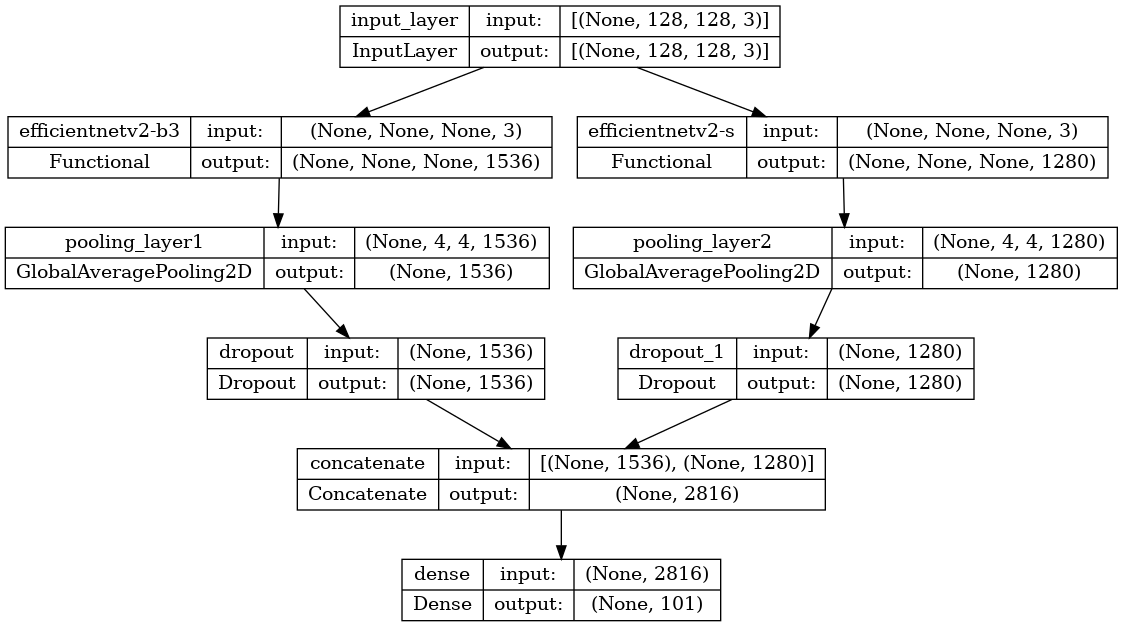

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [6]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=5,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.2 * len(test_data)),
                                                     callbacks=lr_scheduler)

Epoch 1/5


I0000 00:00:1710929984.188077  228852 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 742/2368 [========>.....................] - ETA: 3:21 - loss: nan - accuracy: 0.0119 - top_k_categorical_accuracy: 0.0021